<a href="https://colab.research.google.com/github/ronylitv14/WaterSegmentationApp/blob/main/Water_segmentation_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!kaggle datasets download -d gvclsu/water-segmentation-dataset && unzip water-segmentation-dataset

In [12]:
CUR_DIR = os.getcwd()

PATH_TO_DATASET = os.path.join(CUR_DIR, "water_v2", "water_v2")
PATH_TO_ANNOTATION = os.path.join(PATH_TO_DATASET, "Annotations")
PATH_TO_IMAGES = os.path.join(PATH_TO_DATASET, "JPEGImages")
PATH_TO_DRIVE = os.path.join(CUR_DIR, "drive", "MyDrive")
CHECKPOINT_DIR = os.path.join(CUR_DIR, "model_checkpoints")

MODEL_NAME = "UNet-water-segmentation"

In [5]:
os.mkdir(CHECKPOINT_DIR)

# Data processsing

In [6]:
with open(os.path.join(PATH_TO_DATASET, "train.txt"), "r") as train_file:
  train_dirs = [dir.strip() for dir in train_file.readlines()]

In [7]:
for train_dir in train_dirs:
  img_count = len(os.listdir(os.path.join(PATH_TO_IMAGES, train_dir)))
  print(f"There are {img_count} images in train folder {train_dir}")

There are 1888 images in train folder ADE20K
There are 300 images in train folder river_segs


In [8]:
import glob

img_paths = sorted(glob.glob(os.path.join(PATH_TO_IMAGES, train_dirs[0]) + "/*.png") + glob.glob(os.path.join(PATH_TO_IMAGES, train_dirs[1]) + "/*.jpg"))
annot_paths = sorted(glob.glob(os.path.join(PATH_TO_ANNOTATION, train_dirs[0]) + "/*.png") + glob.glob(os.path.join(PATH_TO_ANNOTATION, train_dirs[1]) + "/*.png"))

In [9]:
assert len(img_paths) == len(annot_paths)

In [10]:
import tensorflow as tf
import numpy as np
import tqdm
import random

IMG_HEIGHT = 224
IMG_WIDTH = 224


def img_load(img_path, image_size=(IMG_HEIGHT, IMG_WIDTH)):
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = tf.image.resize(img, image_size)
    return img / 255.


def get_images(img_paths, annot_paths, number_examples=None):
  if len(img_paths) != len(annot_paths):
    raise ValueError("Image and annotations paths should of equal size!")

  if number_examples is None:
    number_examples = len(img_paths)

  images = []
  annotations = []

  number_examples = np.random.randint(0, len(img_paths)-1, size=number_examples)

  for ind in tqdm.tqdm(number_examples, desc="Loading data..."):
    images.append(img_load(img_paths[ind]))
    annotations.append(img_load(annot_paths[ind]))

  return images, annotations

def convert_data_types(image, mask):
  image = tf.cast(image, dtype=tf.float16)
  mask = tf.cast(mask, dtype=tf.float16)
  return image, mask

def get_dataset(images, annotations):
  ds = tf.data.Dataset.from_tensor_slices((images, annotations))
  ds = ds.map(convert_data_types)
  return ds

In [17]:
NUMBER_OF_IMAGES = 1250

images, annotations = get_images(img_paths, annot_paths, number_examples=NUMBER_OF_IMAGES)
ds = get_dataset(images, annotations)

Loading data...: 100%|██████████| 1250/1250 [00:52<00:00, 23.89it/s]


In [18]:
train_ds, val_ds = tf.keras.utils.split_dataset(ds, left_size=0.8)

In [19]:
print(f"Train dataset: {len(train_ds)}\nValidation dataset: {len(val_ds)}")

Train dataset: 1000
Validation dataset: 250


# Visualizing data

In [16]:
from matplotlib import pyplot as plt


def visualize_image(ax, img, title, axis='off'):
  ax.imshow(img)
  ax.axis(axis)
  ax.set_title(title)


def visualize_img_and_mask(images, masks):
    if len(images) != len(masks):
        raise ValueError("Wrong input! Images and masks should be the same size")

    fig, ax = plt.subplots(nrows=len(images), ncols=2, figsize=(20, 20))

    for ind in range(len(images)):
        visualize_image(ax[ind, 0], images[ind], "Image")
        visualize_image(ax[ind, 1], masks[ind], "Mask")

    plt.tight_layout()
    plt.show()


def get_random_images(images, masks, size=5):
  images_to_display = []
  masks_to_display = []

  for _ in range(size):
    rand_ind = random.randint(0, len(images)- 1)

    images_to_display.append(images[rand_ind])
    masks_to_display.append(masks[rand_ind])

  return images_to_display, masks_to_display

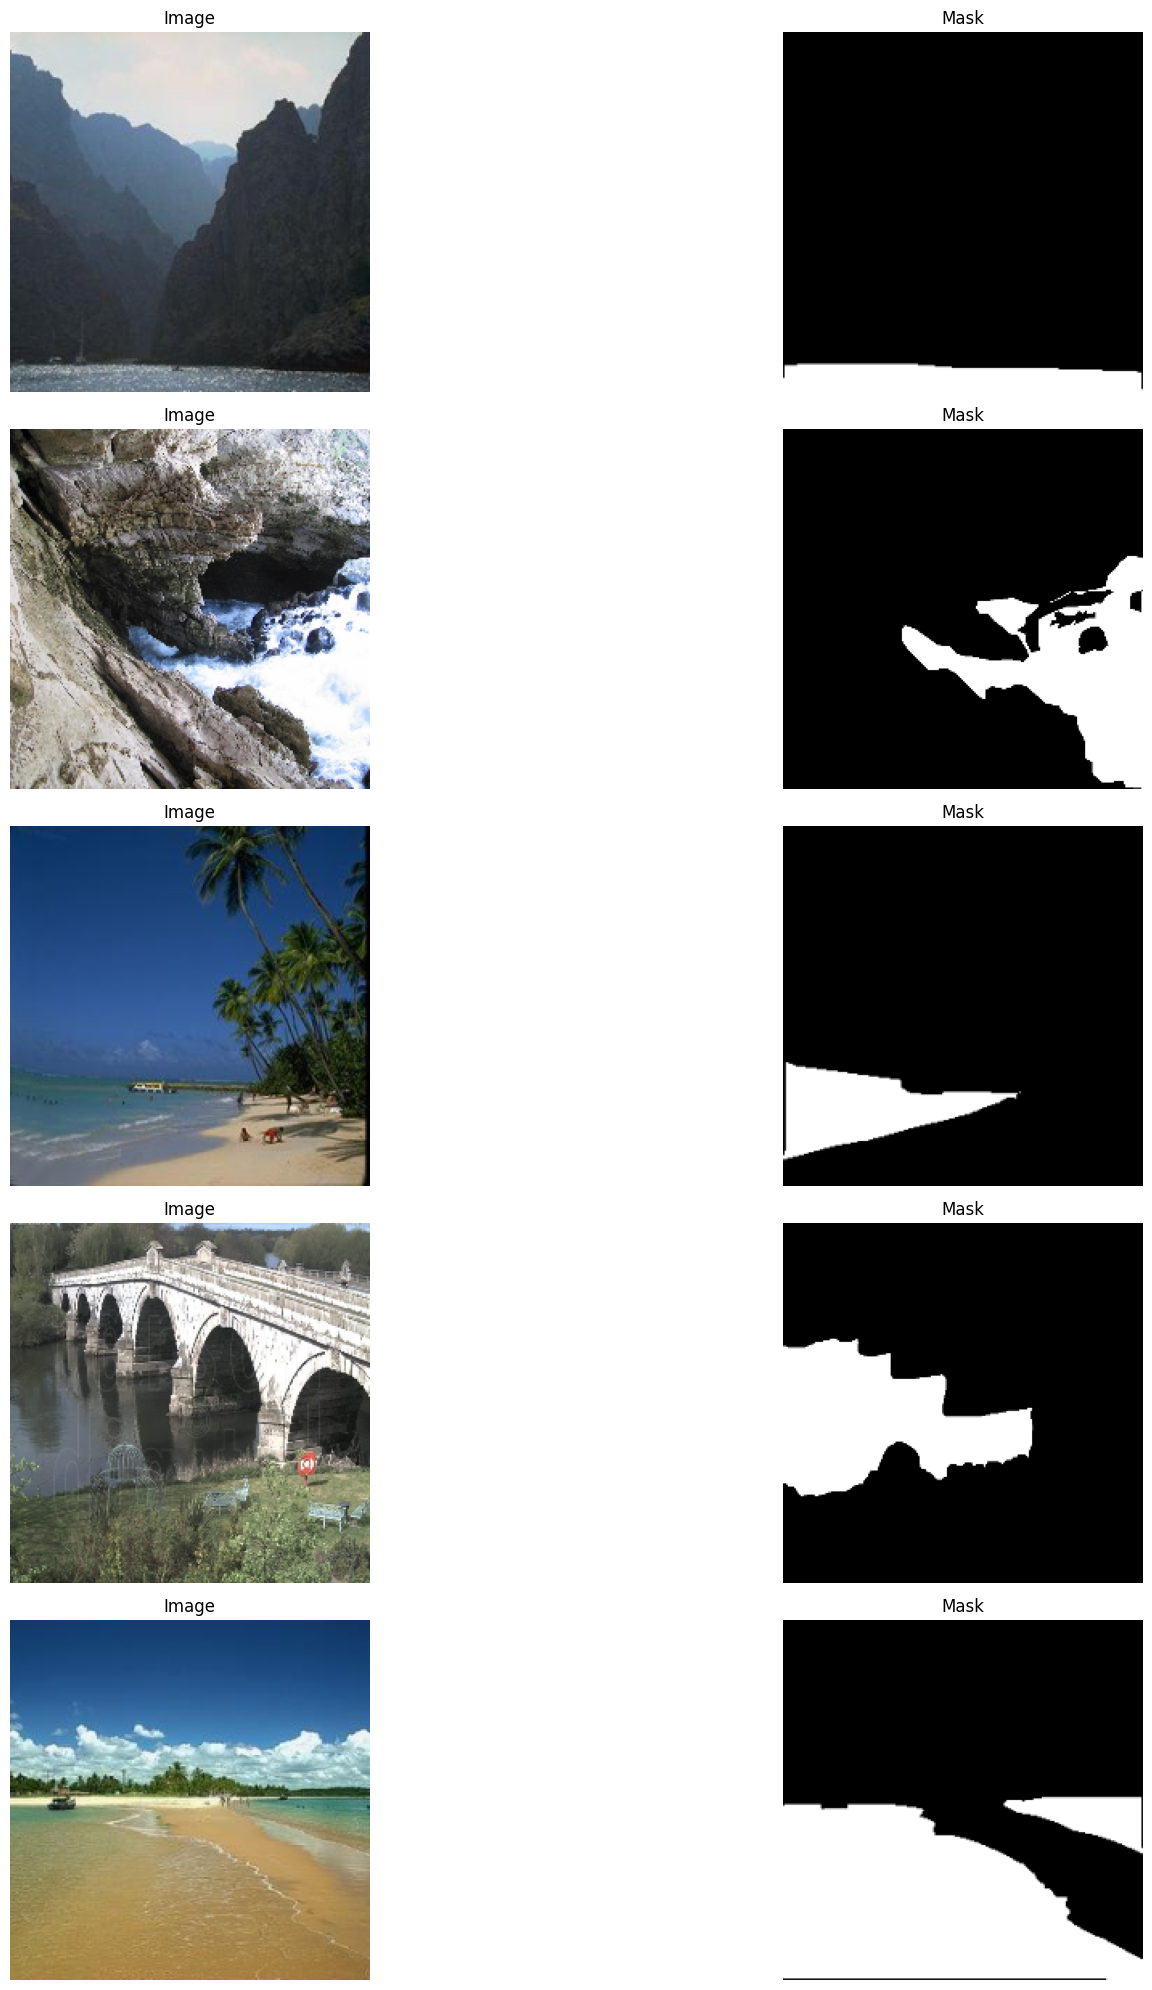

In [20]:
images_to_display, masks_to_display = get_random_images(images, annotations)

visualize_img_and_mask(images_to_display, masks_to_display)

# Model creation

**Model architecture**

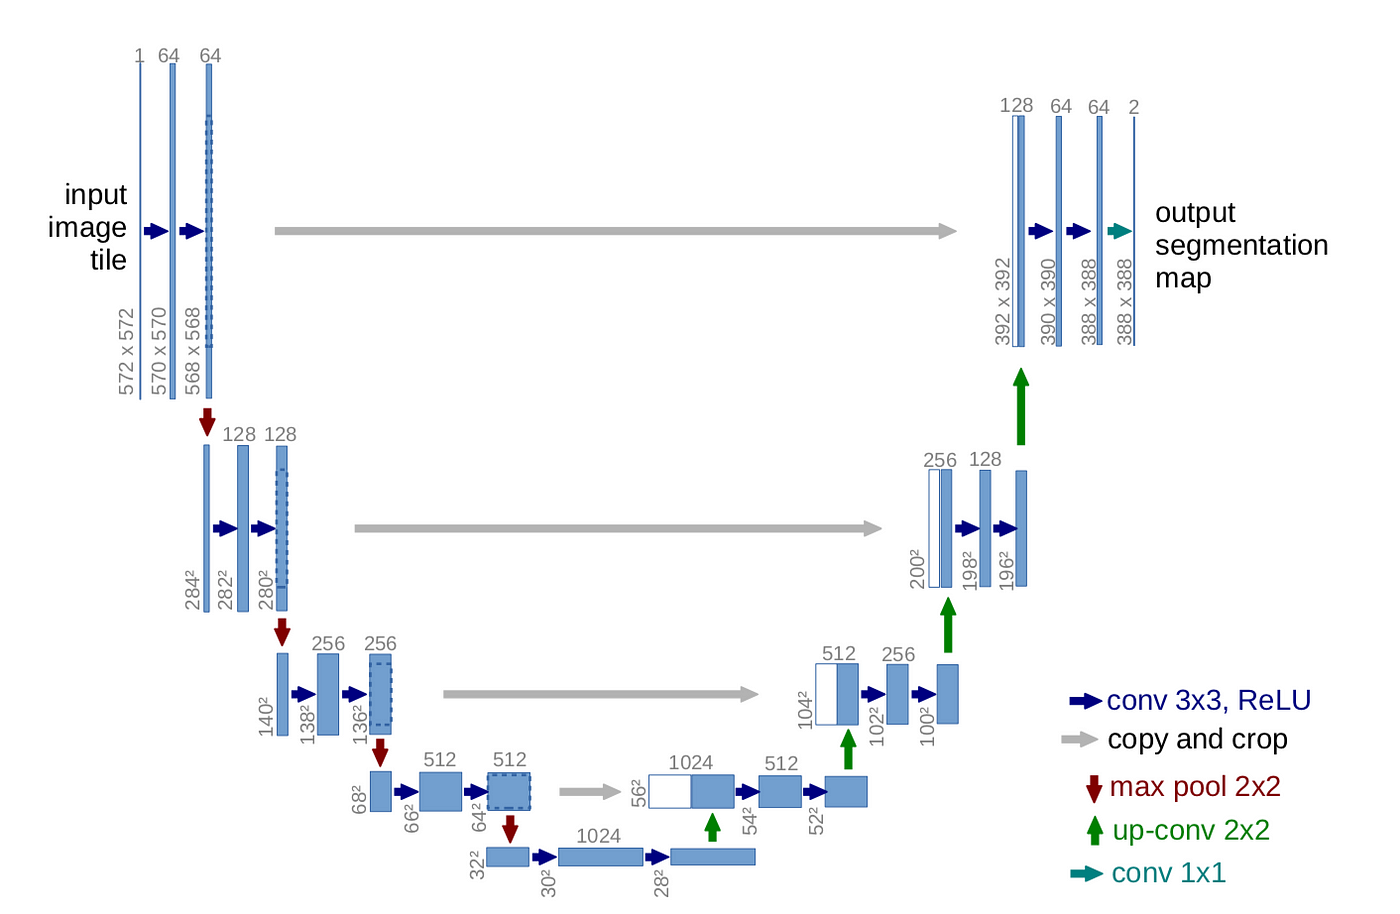

In [ ]:
from keras.layers import MaxPooling2D, Conv2DTranspose, Conv2D, Concatenate, BatchNormalization, Dropout

def create_encoder_block(inputs, filters, kernel_size=(3, 3), activation="relu", padding="same"):
  bn_layer = BatchNormalization()(inputs)
  conv_layer1 = Conv2D(filters, kernel_size, activation=activation, padding=padding)(bn_layer)
  dropout = Dropout(rate=0.2)(conv_layer1)
  conv_layer2 = Conv2D(filters, kernel_size, activation=activation, padding=padding)(conv_layer1)
  max_pool1 = MaxPooling2D(pool_size=(2, 2))(conv_layer2)

  return conv_layer2, max_pool1

def create_decoder_block(inputs, copy_crop_features, filters, kernel_size=(3,3), activation="relu", padding="same"):
  bn_layer = BatchNormalization()(inputs)
  up_conv1 = Conv2DTranspose(filters, (2, 2), strides=(2, 2))(bn_layer)
  concat1 = Concatenate()([up_conv1, copy_crop_features])
  conv_layer1 = Conv2D(filters, kernel_size, activation=activation, padding=padding)(concat1)
  dropout = Dropout(rate=0.2)(conv_layer1)
  conv_layer2 = Conv2D(filters, kernel_size, activation=activation, padding=padding)(conv_layer1)
  return conv_layer2

In [ ]:
from keras.layers import Input, Conv2D
from keras import Model


def create_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)):
  inputs = Input(shape=input_shape)

  # Encoder

  cc_features1, enc1 = create_encoder_block(inputs, 64)
  cc_features2, enc2 = create_encoder_block(enc1, 128)
  cc_features3, enc3 = create_encoder_block(enc2, 256)
  cc_features4, enc4 = create_encoder_block(enc3, 512)

  # Bottleneck

  b1 = Conv2D(1024, 3, activation="relu", padding="same")(enc4)
  b1 = Conv2D(1024, 3, activation="relu", padding="same")(b1)

  # Decoder

  dec1 = create_decoder_block(b1, cc_features4, 512)
  dec2 = create_decoder_block(dec1, cc_features3, 256)
  dec3 = create_decoder_block(dec2, cc_features2, 128)
  dec4 = create_decoder_block(dec3, cc_features1, 64)

  outputs = Conv2D(3, (3, 3), activation="sigmoid", padding="same")(dec4)


  return Model(inputs=inputs, outputs=outputs, name=MODEL_NAME)

In [ ]:
model = create_model((IMG_HEIGHT, IMG_WIDTH, 3))

In [ ]:
model.summary()

Model: "UNet-water-segmentation"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 batch_normalization (Batch  (None, 224, 224, 3)          12        ['input_1[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 conv2d (Conv2D)             (None, 224, 224, 64)         1792      ['batch_normalization[0][0]'] 
                                                                                                  
 conv2d_1 (Conv2D)           (None, 224, 224, 64)         36928     ['conv2d

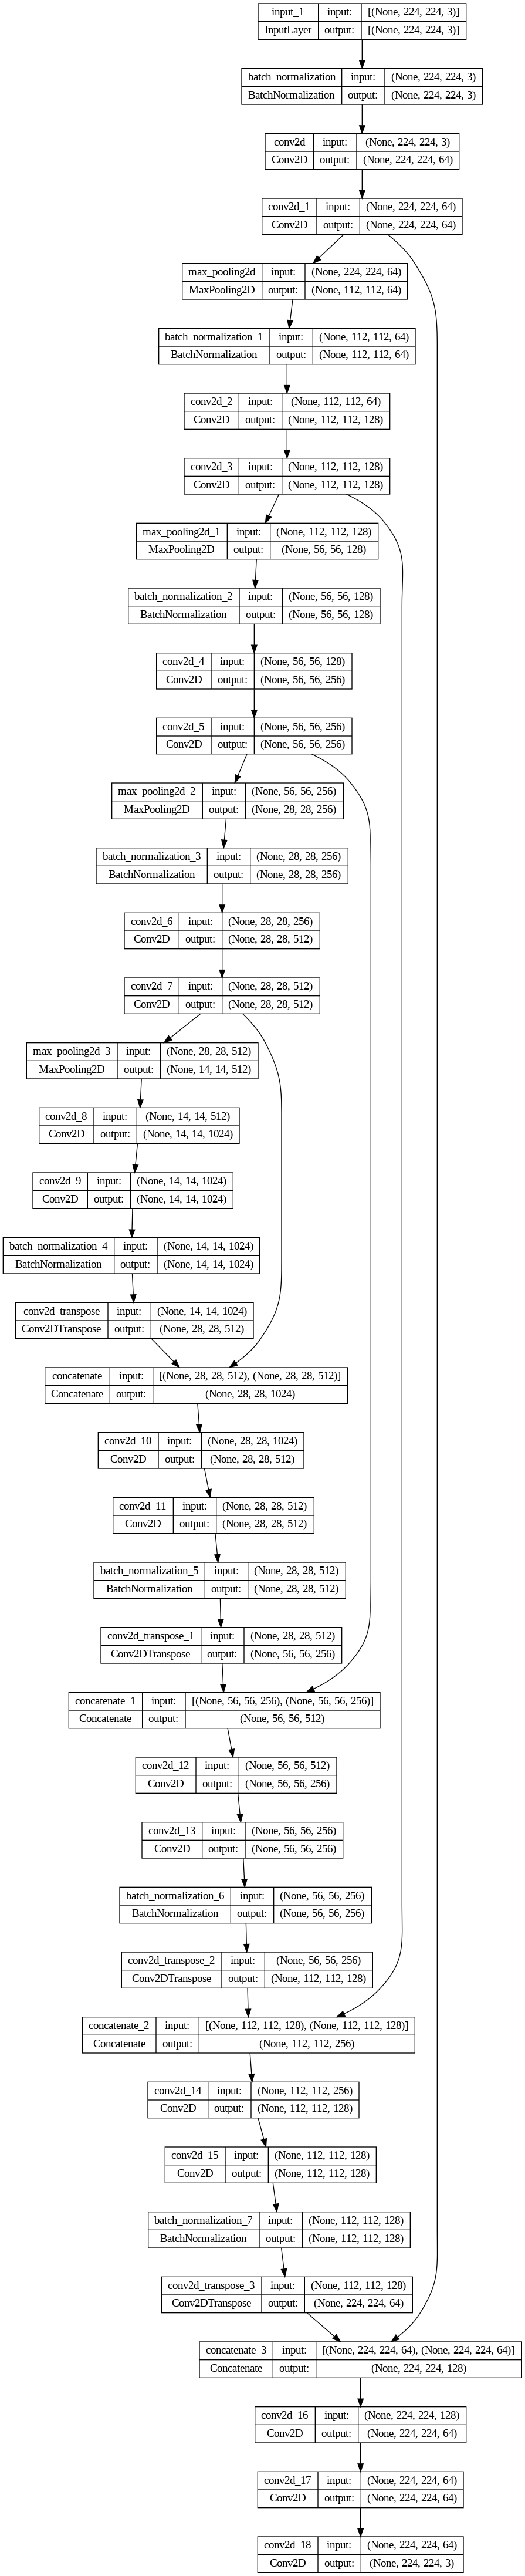

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint

class DisplayResults(Callback):
  def on_epoch_end(self, epoch, *args):
      if epoch % 5 == 0:
          rand_ind = random.randint(0, len(images) - 1)
          img = images[rand_ind]
          mask = annotations[rand_ind]
          pred = self.model.predict(tf.expand_dims(img, axis=0))

          fig, ax = plt.subplots(ncols=3, figsize=(15, 5))

          visualize_image(ax[0], img, "Original image")
          visualize_image(ax[1], mask, "Image mask")
          visualize_image(ax[2], pred[0], "Model prediction")

          plt.show()

checkpoint_filepath = os.path.join(CHECKPOINT_DIR, 'checkpoint.weights.h5')

display_callback = DisplayResults()

early_stopping_callback = EarlyStopping(
    monitor="val_loss",
    patience=5,
    start_from_epoch=25
)


model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

callbacks = [display_callback, early_stopping_callback, model_checkpoint_callback]

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adamax(),
    loss=tf.keras.losses.BinaryCrossentropy(),
)

In [ ]:
def augment(image, mask):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_up_down(image)
        mask = tf.image.flip_up_down(mask)
    return image, mask

In [ ]:
train_ds = train_ds.map(augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_ds = train_ds.batch(batch_size=32)
val_ds = val_ds.batch(batch_size=16)

In [ ]:
train_ds.element_spec

(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float16, name=None),
 TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float16, name=None))

Epoch 1/30
      6/Unknown - 7s 1s/step - loss: 0.7288

1/1 [==============================] - 0s 18ms/step


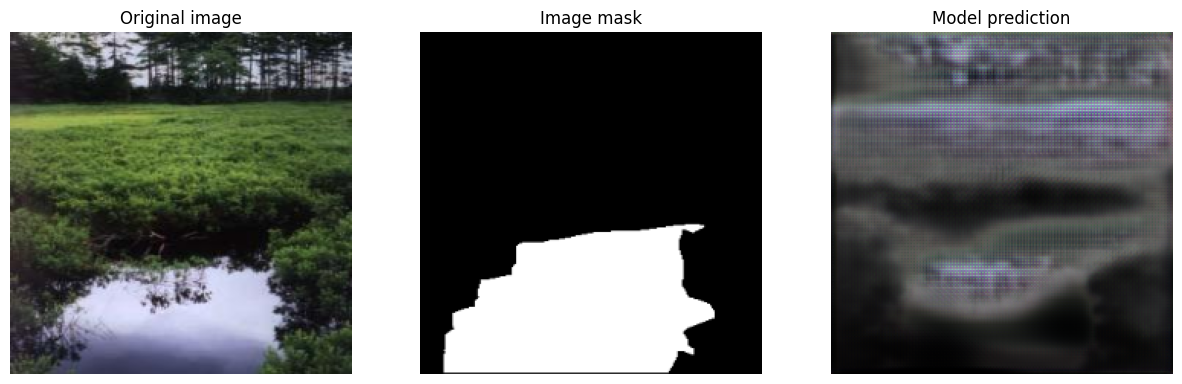

32/32 [==============================] - 41s 1s/step - loss: 0.4552 - val_loss: 0.5409
Epoch 2/30
32/32 [==============================] - 41s 1s/step - loss: 0.3396 - val_loss: 0.3840
Epoch 3/30
32/32 [==============================] - 40s 1s/step - loss: 0.3013 - val_loss: 0.3750
Epoch 4/30
32/32 [==============================] - 41s 1s/step - loss: 0.2969 - val_loss: 0.3669
Epoch 5/30
32/32 [==============================] - 45s 1s/step - loss: 0.2665 - val_loss: 0.3535
Epoch 6/30
1/1 [==============================] - 0s 19ms/step


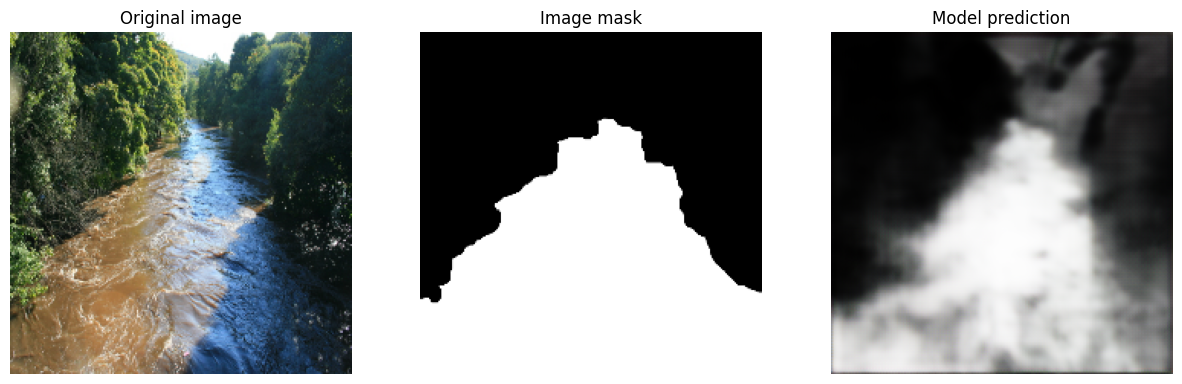

32/32 [==============================] - 41s 1s/step - loss: 0.2532 - val_loss: 0.3783
Epoch 7/30
32/32 [==============================] - 41s 1s/step - loss: 0.2461 - val_loss: 0.3737
Epoch 8/30
32/32 [==============================] - 41s 1s/step - loss: 0.2382 - val_loss: 0.3695
Epoch 9/30
32/32 [==============================] - 41s 1s/step - loss: 0.2249 - val_loss: 0.3765
Epoch 10/30
32/32 [==============================] - 41s 1s/step - loss: 0.2114 - val_loss: 0.3564
Epoch 11/30
1/1 [==============================] - 0s 30ms/step


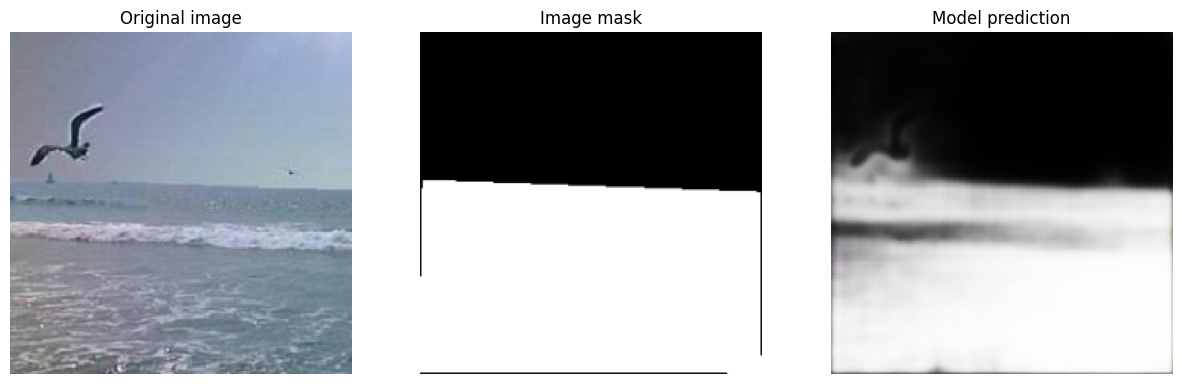

32/32 [==============================] - 43s 1s/step - loss: 0.2019 - val_loss: 0.3300
Epoch 12/30
32/32 [==============================] - 41s 1s/step - loss: 0.1974 - val_loss: 0.3829
Epoch 13/30
32/32 [==============================] - 41s 1s/step - loss: 0.1953 - val_loss: 0.4303
Epoch 14/30
32/32 [==============================] - 41s 1s/step - loss: 0.1929 - val_loss: 0.4457
Epoch 15/30
32/32 [==============================] - 41s 1s/step - loss: 0.1819 - val_loss: 0.3718
Epoch 16/30
1/1 [==============================] - 0s 43ms/step


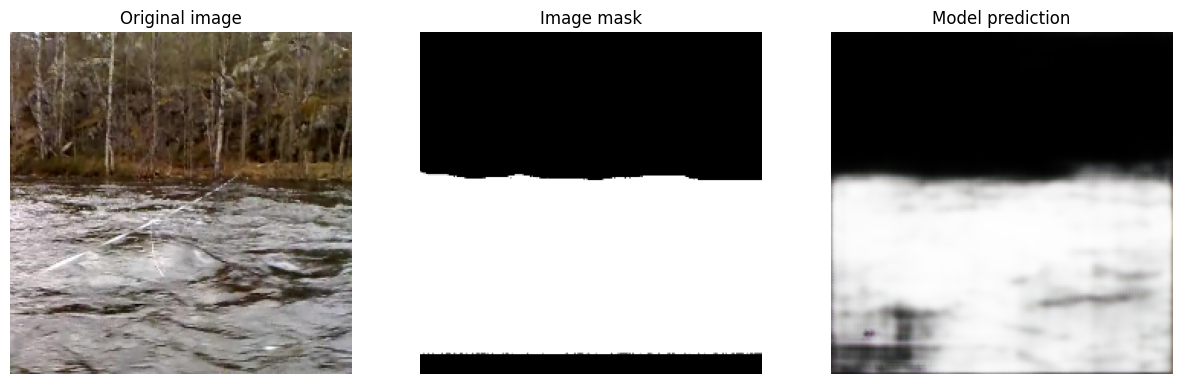

32/32 [==============================] - 41s 1s/step - loss: 0.1766 - val_loss: 0.3457
Epoch 17/30
32/32 [==============================] - 41s 1s/step - loss: 0.1648 - val_loss: 0.4005
Epoch 18/30
32/32 [==============================] - 41s 1s/step - loss: 0.1650 - val_loss: 0.3801
Epoch 19/30
32/32 [==============================] - 41s 1s/step - loss: 0.1563 - val_loss: 0.3339
Epoch 20/30
32/32 [==============================] - 41s 1s/step - loss: 0.1594 - val_loss: 0.3840
Epoch 21/30
1/1 [==============================] - 0s 19ms/step


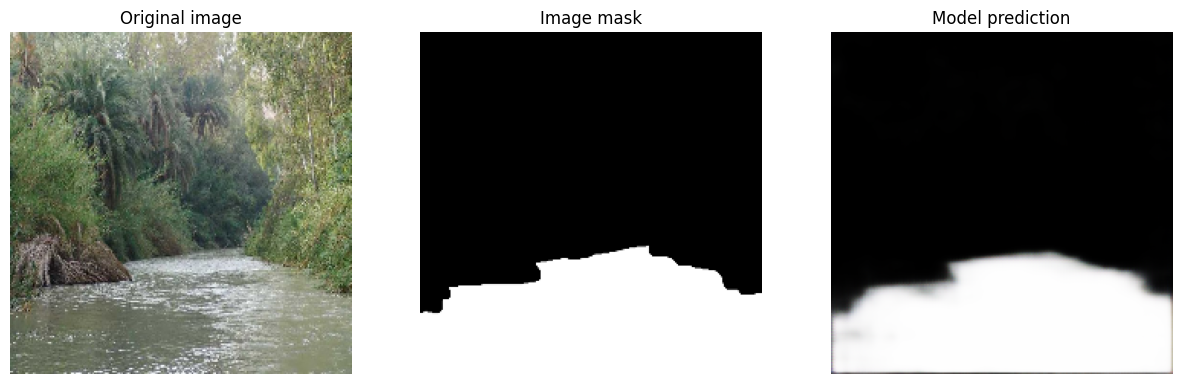

32/32 [==============================] - 41s 1s/step - loss: 0.1485 - val_loss: 0.4354
Epoch 22/30
32/32 [==============================] - 41s 1s/step - loss: 0.1450 - val_loss: 0.3550
Epoch 23/30
32/32 [==============================] - 41s 1s/step - loss: 0.1458 - val_loss: 0.4368
Epoch 24/30
32/32 [==============================] - 41s 1s/step - loss: 0.1339 - val_loss: 0.4594
Epoch 25/30
32/32 [==============================] - 41s 1s/step - loss: 0.1411 - val_loss: 0.5580
Epoch 26/30
1/1 [==============================] - 0s 19ms/step


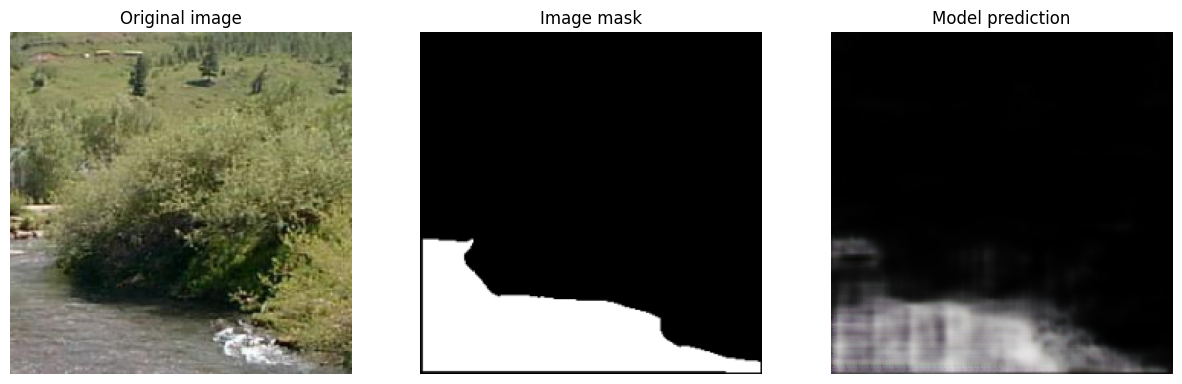

32/32 [==============================] - 41s 1s/step - loss: 0.1273 - val_loss: 0.4040
Epoch 27/30
32/32 [==============================] - 41s 1s/step - loss: 0.1209 - val_loss: 0.4132
Epoch 28/30
32/32 [==============================] - 41s 1s/step - loss: 0.1232 - val_loss: 0.4141
Epoch 29/30
32/32 [==============================] - 41s 1s/step - loss: 0.1230 - val_loss: 0.4312
Epoch 30/30
32/32 [==============================] - 41s 1s/step - loss: 0.1133 - val_loss: 0.4128


In [ ]:
history = model.fit(
    train_ds,
    epochs=30,
    validation_data=val_ds,
    callbacks=callbacks
)

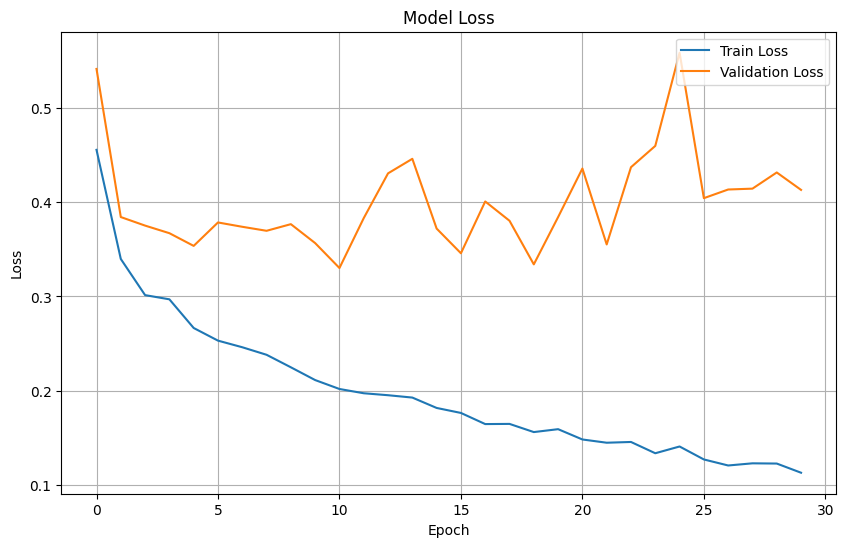

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [ ]:
model.load_weights(os.path.join(CHECKPOINT_DIR, checkpoint_filepath))

In [ ]:
model.evaluate(val_ds)

16/16 [==============================] - 3s 187ms/step - loss: 0.3300


0.3300471305847168

In [ ]:
model.save(os.path.join(PATH_TO_DRIVE, "Models", MODEL_NAME + ".keras"))

# Displaying model results

In [13]:
model = tf.keras.models.load_model(os.path.join(PATH_TO_DRIVE, "Models", MODEL_NAME + ".keras"))

In [21]:
import ipywidgets as widgets

possible_test_images = sorted(os.listdir(PATH_TO_IMAGES))
test_folder = widgets.Dropdown(
    options=possible_test_images,
    value=possible_test_images[0]
    )

test_folder

Dropdown(options=('ADE20K', 'aberlour', 'auldgirth', 'bewdley', 'boston_harbor2_small_rois', 'buffalo0_small',…

In [24]:
test_image_paths = sorted(glob.glob(os.path.join(PATH_TO_IMAGES, test_folder.value) + "/*.jpg"))
test_annot_paths = sorted(glob.glob(os.path.join(PATH_TO_ANNOTATION, test_folder.value) + "/*.png"))

In [25]:
assert len(test_image_paths) == len(test_annot_paths)

In [26]:
x_test, y_test = get_images(test_image_paths, test_annot_paths)

Loading data...: 100%|██████████| 300/300 [00:11<00:00, 26.35it/s]


In [27]:
def overlay_mask_on_image(image, mask, alpha=0.8, mask_measure=0.2):
    mask_rgb = np.where(mask > mask_measure, [1, 1, 0], [0, 0, 0])
    overlay = np.clip(image + mask_rgb * alpha, 0, 1)
    return overlay

def visualize_results(images, masks, model, number_examples=5, prob_measure=0.3):
  fig, ax = plt.subplots(nrows=number_examples, ncols=5)

  fig.set_figwidth(25)
  fig.set_figheight(20)

  for ind in range(number_examples):
    random_ind = random.randint(0, len(images) - 1)

    pred = model.predict(tf.expand_dims(images[random_ind], axis=0))
    overlay = overlay_mask_on_image(
        images[random_ind],
        pred[0],
        mask_measure=prob_measure
    )

    visualize_image(ax[ind, 0], images[random_ind], "Original image")
    visualize_image(ax[ind, 1], masks[random_ind], "Mask")
    visualize_image(ax[ind, 2], pred[0], "Prediction")
    visualize_image(ax[ind, 3], pred[0][:,:,0] > prob_measure, "Prediction with prob")
    visualize_image(ax[ind, 4], overlay, "Image with overlay")

1/1 [==============================] - 0s 18ms/step


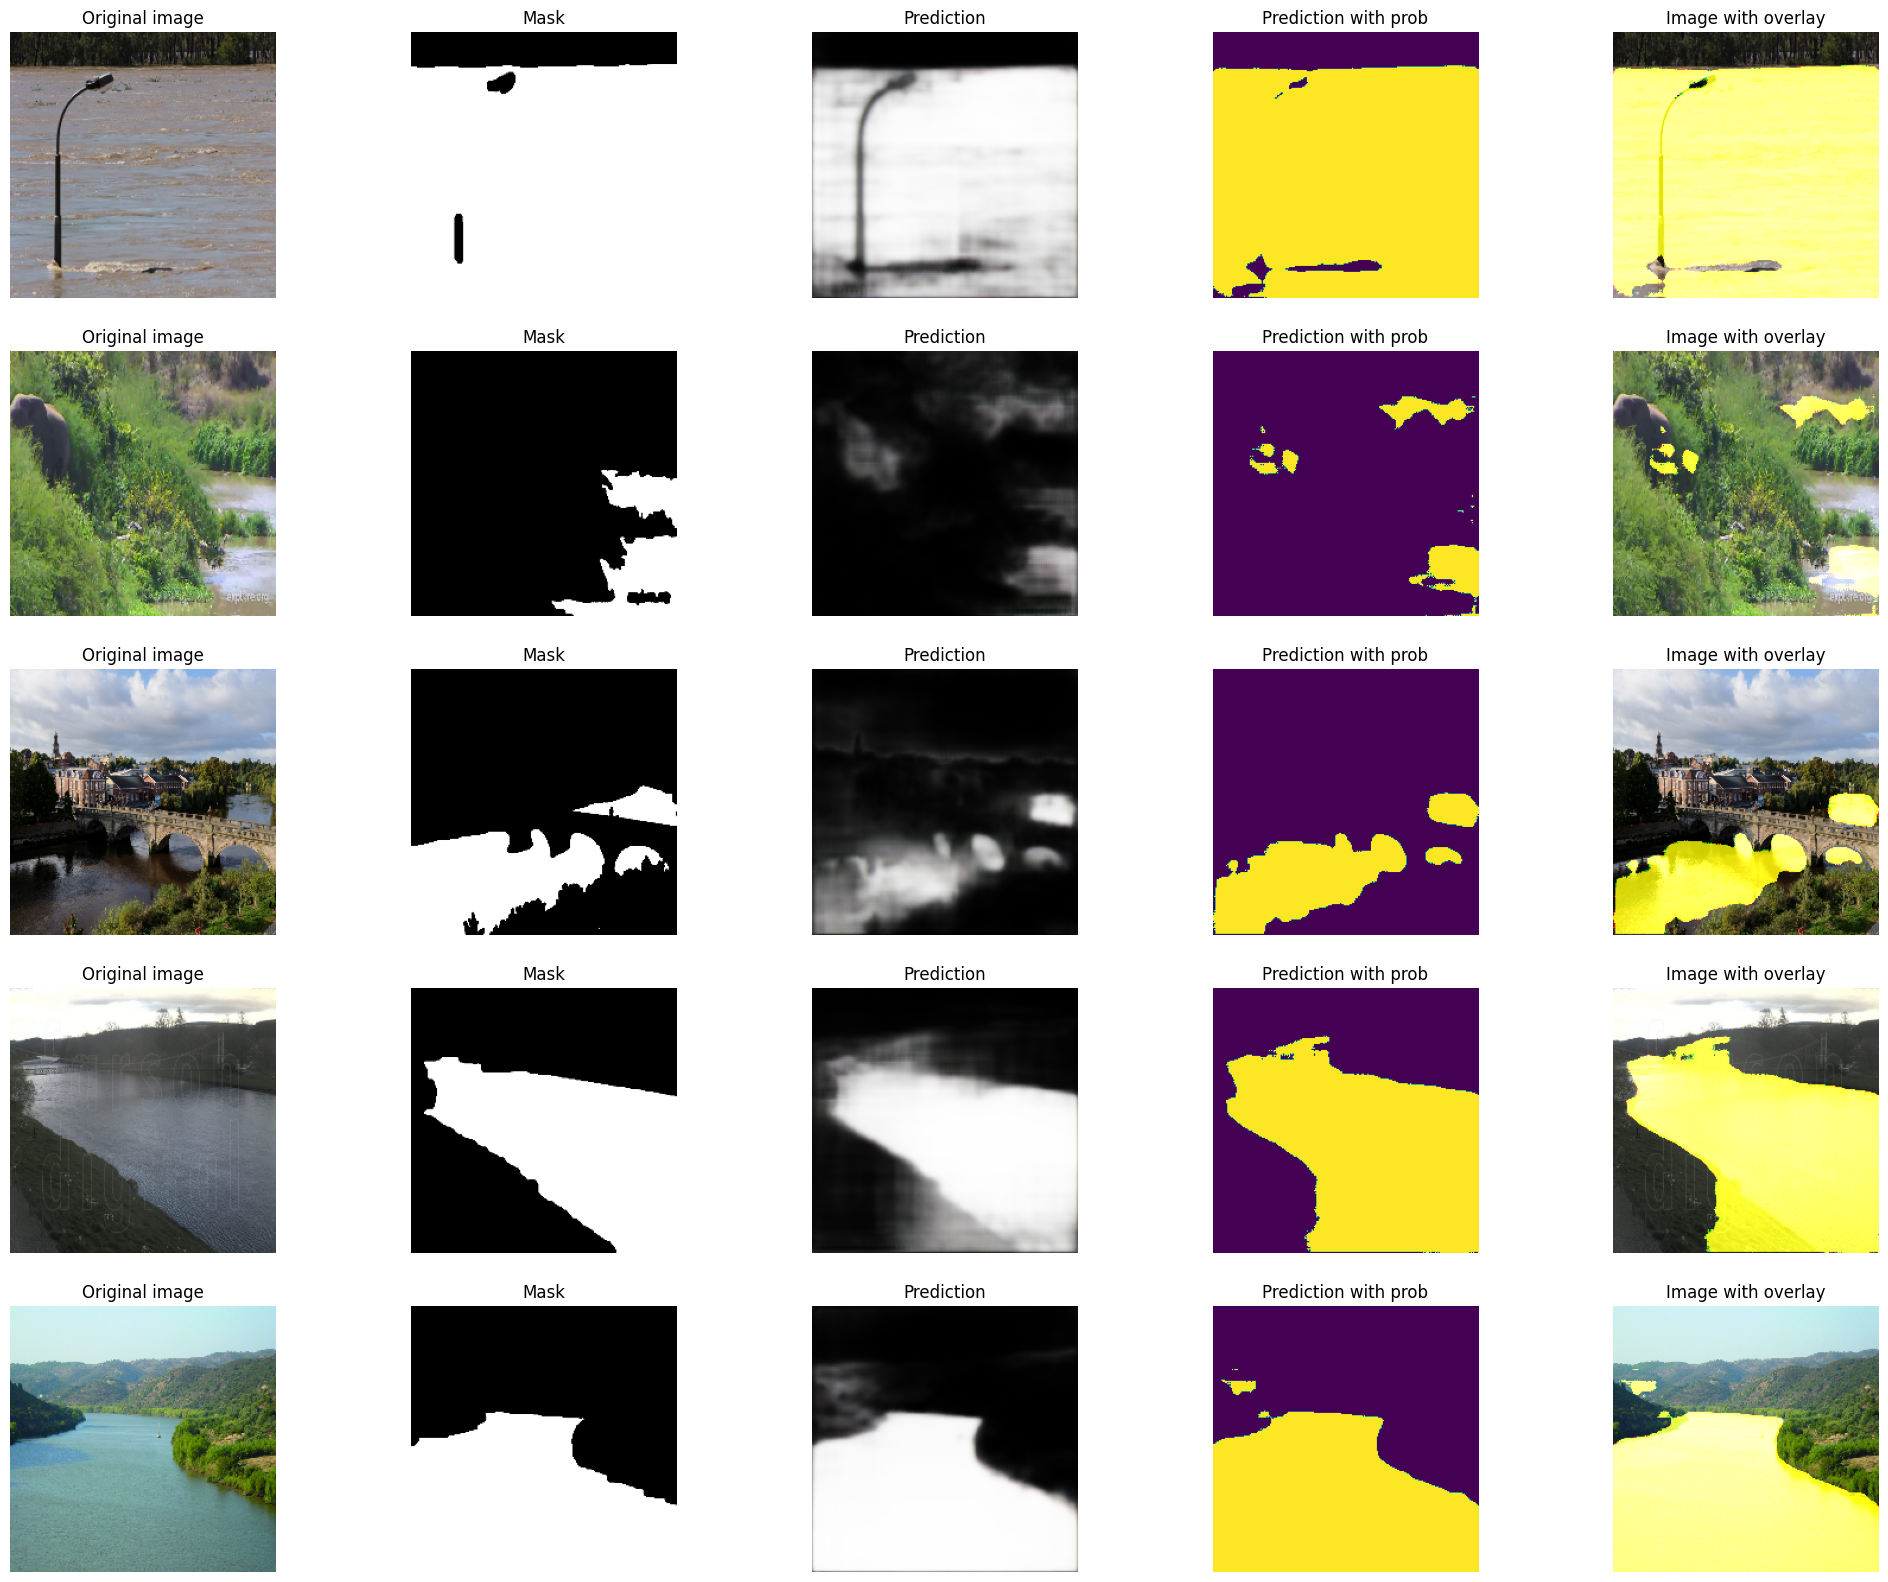

In [ ]:
visualize_results(x_test, y_test, model=model)